In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import norm

from cnp.data import GPGenerator

from cnp.cnp import StandardConvGNP
from cnp.cov import InnerProdCov, MeanFieldCov, AddNoNoise, AddHomoNoise

import stheno

import matplotlib
matplotlib.rcParams['text.usetex'] = True

In [2]:
plot_grid_res = 100
num_samples = 50
xmin = -4.5
xmax = 4.5
ymin = -5
ymax = 5
num_basis_dim = 512

/Users/stratis/repos/kernelcnp/venv-gnp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
kernel = stheno.EQ().stretch(1.)
std_noise = 1e-1

gen_params = {
    'batch_size'                : 1,
    'x_context_ranges'          : [[-3., 3.]],
    'max_num_context'           : 3,
    'min_num_target'            : 3,
    'max_num_target'            : 10,
    'device'                    : 'cpu'
}

gen = GPGenerator(iterations_per_epoch=1,
                  kernel=kernel,
                  std_noise=std_noise,
                  **gen_params)

seed = 5

/Users/stratis/repos/kernelcnp/venv-gnp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Mean field ConvGNP

In [7]:
inner_prod_cov = InnerProdCov(num_basis_dim=num_basis_dim)
add_homo_noise = AddHomoNoise()

innerprod_conv_gnp_path = './models/innerprod-convGNP'

model = StandardConvGNP(input_dim=1,
                        covariance=inner_prod_cov,
                        add_noise=add_homo_noise,
                        num_noise_channels=0)

model.load_state_dict(torch.load(innerprod_conv_gnp_path, map_location=torch.device('cpu'))['state_dict'])

np.random.seed(seed)
torch.manual_seed(seed)

data = list(gen)[0]

x_context = data['x_context']
x_target = data['x_target']
y_context = data['y_context']
y_target = data['y_target']

x_plot = torch.linspace(xmin, xmax, plot_grid_res)[None, :, None]
x_plot_rep = x_plot[:, :, 0].repeat(num_samples, 1)
x_plot = x_plot.repeat(x_context.shape[0], 1, 1)

model_output = model(x_context, y_context, x_plot)
mean, cov, cov_plus_noise = [v.detach().numpy() for v in model_output]

/Users/stratis/repos/kernelcnp/venv-gnp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/stratis/repos/kernelcnp/venv-gnp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


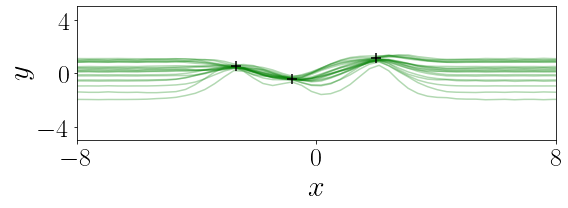

In [24]:
num_samples = 1000
plot_samples = 20

x_pred = np.array([[[0.], [0.5]]])
x_pred = torch.tensor(np.linspace(-16., 16., 100)).float()[None, :, None]

model_output = model(x_context, y_context, x_pred)
mean_pred, cov_pred, _ = [v.detach().numpy() for v in model_output]

x_pred = x_pred.numpy()

std_dev = np.diag(cov[0]) ** 0.5

np.random.seed(2)

cov_corr = cov_pred[0, :, :]
chol_corr = np.linalg.cholesky(cov_corr + 1e-5 * np.eye(cov_corr.shape[0]))
noise = np.random.randn(cov_corr.shape[0], num_samples)
samples_corr = mean_pred[0, :, :] + chol_corr @ noise

samples_corr = mean_pred[0, :, :] + chol_corr @ noise

f, ax0 = plt.subplots(1, 1, gridspec_kw={'width_ratios': [1]}, figsize=(8., 3.))
    
#==============================================================================
# First plot
#==============================================================================

ax0.scatter(x_context[0, :, 0],
            y_context[0, :, 0],
            marker='+',
            color='black',
            s=100,
            zorder=2)

ax0.plot(x_pred[0, :, 0],
         samples_corr[:, -plot_samples:],
         color='green',
         alpha=0.3,
         zorder=1)

ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymin, ymax])
ax0.set_xticks(np.linspace(-8., 8., 3))
ax0.set_yticks(np.linspace(-4., 4., 3))
ax0.set_xlabel('$x$', fontsize=30)
ax0.set_ylabel('$y$', fontsize=30)
for t in ax0.xaxis.get_major_ticks():
    t.label.set_fontsize(26)
for t in ax0.yaxis.get_major_ticks():
    t.label.set_fontsize(26)
    
plt.tight_layout()
plt.savefig('./plots/feature-failure.pdf')
plt.show()